# 🛰️ Satellite Land Cover Analysis (2‑minute quickstart)

## 1) Install
From the repo root:
- `pip install -e .`
- `pip install -e ".[notebooks]"`

## 2) Add Copernicus credentials
Set your Copernicus Data Space credentials in `config/config.yaml` (see `config/config.yaml.example`).

## 3) Run this notebook (top → bottom)

### Configuration (Cell 3)
Edit parameters:
- `CITY` (e.g. "Milan")
- `CLASSIFIER`: `"consensus"` (default), `"kmeans"` (fast), `"spectral"` (SWIR-based)
- `MAX_CLOUD_COVER`, `START_DATE`, `END_DATE`, `RADIUS_KM`, `MAX_SIZE`

### Product Selection (Cells 4-5) - REQUIRED
Manual product selection workflow:

- **Cell 4**: Search available products → see list with dates and cloud cover
- **Cell 5**: Set `SELECTED_PRODUCT_INDEX` → downloads selected product
- **Cell 6**: Preview RGB composite (optional)

### Analysis (Cell 7)
Run `analyze()` → uses pre-downloaded bands from Cell 5

## What you get
Outputs are written to `data/cities/<city>/runs/<timestamp>_<classifier>/` including:
- `labels.npy`, `confidence.npy`, `run_info.json`
- optional exports: GeoTIFF / HTML report / JSON / PNG summary / RGB composites

In [1]:
# ========================================
# 📦 Setup (run once after kernel restart)
# ========================================

import sys
import warnings
from pathlib import Path
from datetime import datetime, timedelta

# Suppress numpy divide warnings (expected with satellite data)
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*divide.*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*invalid value.*')

# Setup path (only needed when running from notebooks/)
project_root = Path.cwd().parent
if str(project_root / 'src') not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))

# Core imports
from satellite_analysis import (
    analyze, 
    export_geotiff, export_report, export_json, export_image,
    export_rgb,  # NEW: RGB True Color export
)
from satellite_analysis.utils import AreaSelector
from satellite_analysis.pipelines.download_pipeline import DownloadPipeline
from satellite_analysis.exports import LAND_COVER_CLASSES

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import numpy as np

# Land cover classes (single source of truth)
CLASSES = {k: {"name": v["name"], "color": v["color"]} for k, v in LAND_COVER_CLASSES.items()}

print("✅ Ready to analyze!")
print(f"   Color palette: {[v['color'] for v in CLASSES.values()]}")

✅ Ready to analyze!
   Color palette: ['#1E90FF', '#228B22', '#CD853F', '#DC143C', '#FFD700', '#4B0082']


In [2]:
# ========================================
# ⚙️ Configuration
# ========================================

# === CITY ===
# Milan, Rome, Florence..
# Or use any city name (will geocode automatically)
CITY_DISPLAY = "Naples, Italy"  # Display name with proper formatting
CITY = CITY_DISPLAY.lower().replace(", ", "_").replace(" ", "_")  # Normalized for analysis and filesystem

# === AREA ===
# Radius around city center in km (defines the analysis area)
# 💡 TIP: Use smaller radius (3-5km) for dense urban areas
#         Use larger radius (15-20km) to include suburbs
RADIUS_KM = 10  # Smaller radius = more urban focus

# === DATE RANGE ===
# Leave as None to use last 60 days, or specify dates
END_DATE = "2025-08-30"  # e.g., "2025-01-15" or None for today
START_DATE = "2025-06-30" # e.g., "2024-12-01" or None for 60 days before end_date

# === QUALITY FILTERS ===
MAX_CLOUD_COVER = 25  # Maximum cloud coverage % (0-100)
CROP_TO_CITY = True   # True = centered on city, False = full satellite tile

# === PROCESSING ===
MAX_SIZE = None       # Max image dimension in pixels (None = full resolution)
                      # Recommended: 2000-5000 for balance of speed/detail

# Classification method: "consensus" (default), "kmeans" (fast), "spectral" (SWIR-based)
CLASSIFIER = "kmeans"
N_CLUSTERS = 6  # Number of clusters (used for kmeans and consensus)

# RAW CLUSTERS MODE (NEW!)
# True  = Keep distinct cluster IDs (0 to N_CLUSTERS-1) - better for visualization
# False = Map clusters to semantic classes (Water, Vegetation, Urban, etc.)
RAW_CLUSTERS = True  # ⭐ Recommended for kmeans to see all clusters

# === CALCULATED DATES ===
if END_DATE is None:
    END_DATE = datetime.now().strftime("%Y-%m-%d")
if START_DATE is None:
    START_DATE = (datetime.now() - timedelta(days=60)).strftime("%Y-%m-%d")

# Show configuration
area_km2 = 3.14159 * RADIUS_KM ** 2  # Approximate circular area
clusters_str = f" ({N_CLUSTERS} clusters)" if CLASSIFIER in ("kmeans", "consensus") else ""
raw_str = " [RAW MODE]" if RAW_CLUSTERS and CLASSIFIER == "kmeans" else ""
print(f"""
📍 Analysis Configuration
{'='*40}
City:         {CITY}
Radius:       {RADIUS_KM} km (~{area_km2:.0f} km²)
Date range:   {START_DATE} to {END_DATE}
Cloud cover:  ≤{MAX_CLOUD_COVER}%
Crop to city: {CROP_TO_CITY}
Max size:     {MAX_SIZE or 'Full resolution'}
Classifier:   {CLASSIFIER}{clusters_str}{raw_str}

💡 RAW_CLUSTERS=True keeps all {N_CLUSTERS} clusters distinct!
   Set False to map to semantic classes (Water, Veg, Urban...)
""")


📍 Analysis Configuration
City:         naples_italy
Radius:       10 km (~314 km²)
Date range:   2025-06-30 to 2025-08-30
Cloud cover:  ≤25%
Crop to city: True
Max size:     Full resolution
Classifier:   kmeans (6 clusters) [RAW MODE]

💡 RAW_CLUSTERS=True keeps all 6 clusters distinct!
   Set False to map to semantic classes (Water, Veg, Urban...)



In [ ]:
# ========================================
# 🔍 Search Available Products (Optional)
# ========================================
# Run this cell to see available products before downloading
# You can skip this and directly set SELECTED_PRODUCT_INDEX in Cell 5

# Get city bounding box
area_selector = AreaSelector()
bbox, metadata = area_selector.select_by_city(CITY_DISPLAY, radius_km=RADIUS_KM)

print(f"🔍 Searching products for {CITY_DISPLAY}...")
print(f"   Center: {metadata['center']}")
print(f"   Area: {metadata['area_km2']:.1f} km²")
print(f"   Bbox: {[round(x, 4) for x in bbox]}")

# Search products (requires API credentials)
try:
    download_pipeline = DownloadPipeline.from_config(str(project_root / "config" / "config.yaml"))
    
    # Use the pipeline's catalog (already authenticated)
    results = download_pipeline.search(
        bbox=bbox,
        start_date=START_DATE,
        end_date=END_DATE,
        limit=20
    )
    
    products = results.get('features', [])
    
    if products:
        print(f"\n📦 Found {len(products)} products:\n")
        print(f"{'Index':<6} {'Date':<12} {'Cloud%':<8} {'Product ID':<50}")
        print("-" * 80)
        for i, p in enumerate(products):
            props = p.get('properties', {})
            date = props.get('datetime', 'N/A')[:10]
            cloud = props.get('eo:cloud_cover', 'N/A')
            pid = p.get('id', 'N/A')[:48]
            print(f"{i:<6} {date:<12} {cloud:<8.1f} {pid}")
        
        # Store for later use
        AVAILABLE_PRODUCTS = products
        print(f"\n💡 {len(products)} products stored in AVAILABLE_PRODUCTS variable")
        print(f"   Use index 0-{len(products)-1} to select a product in the next cell")
    else:
        print("⚠️ No products found with current filters. Try:")
        print("   - Increasing MAX_CLOUD_COVER")
        print("   - Extending the date range")
        AVAILABLE_PRODUCTS = []
        
except FileNotFoundError:
    print("⚠️ Config file not found. Check config/config.yaml")
    AVAILABLE_PRODUCTS = []
except Exception as e:
    print(f"⚠️ Could not search products: {e}")
    print("   Check your Copernicus credentials in config/config.yaml")
    AVAILABLE_PRODUCTS = []

🔍 Searching products for Naples, Italy...
   Center: (42.6484404, -77.3611772)
   Area: 397.9 km²
   Bbox: [-77.4831, 42.5584, -77.2392, 42.7385]

📦 Found 7 products:

Index  Date         Cloud%   Product ID                                        
--------------------------------------------------------------------------------
0      2025-08-15   15.3     S2C_MSIL2A_20250815T155921_N0511_R097_T17TQH_202
1      2025-08-15   12.1     S2C_MSIL2A_20250815T155921_N0511_R097_T18TUN_202
2      2025-08-10   14.9     S2B_MSIL2A_20250810T155819_N0511_R097_T18TUN_202
3      2025-08-05   7.6      S2C_MSIL2A_20250805T155841_N0511_R097_T17TQH_202
4      2025-08-05   10.9     S2C_MSIL2A_20250805T155841_N0511_R097_T18TUN_202
5      2025-07-28   2.0      S2A_MSIL2A_20250728T160711_N0511_R097_T17TQH_202
6      2025-07-28   11.1     S2A_MSIL2A_20250728T160711_N0511_R097_T18TUN_202

💡 7 products stored in AVAILABLE_PRODUCTS variable
   Use index 0-6 to select a product in the next cell


In [ ]:
# ========================================
# 🎯 Select & Download Specific Product
# ========================================
# Select and download a specific product from the search results above

# Set the product index from the list shown in Cell 4
SELECTED_PRODUCT_INDEX = 5

# OR: Choose a specific product from the search results
# Example: SELECTED_PRODUCT_INDEX = 0  # First product from the list
#          SELECTED_PRODUCT_INDEX = 2  # Third product from the list

if AVAILABLE_PRODUCTS and SELECTED_PRODUCT_INDEX is not None:
    if 0 <= SELECTED_PRODUCT_INDEX < len(AVAILABLE_PRODUCTS):
        selected = AVAILABLE_PRODUCTS[SELECTED_PRODUCT_INDEX]
        props = selected.get('properties', {})
        date = props.get('datetime', 'N/A')[:10]
        cloud = props.get('eo:cloud_cover', 'N/A')
        product_name = selected.get('id', 'N/A')
        
        print(f"✅ Selected product at index {SELECTED_PRODUCT_INDEX}:")
        print(f"   Date: {date}")
        print(f"   Cloud: {cloud:.1f}%")
        print(f"   Name: {product_name}")
        
        # Download the selected product
        print(f"\n📥 Downloading and extracting bands...")
        try:
            from satellite_analysis.downloaders.product_downloader import ProductDownloader
            from satellite_analysis.preprocessors.band_extractor import BandExtractor
            
            # Setup download
            download_pipeline = DownloadPipeline.from_config(str(project_root / "config" / "config.yaml"))
            output_dir = project_root / "data" / "cities" / CITY / "raw"
            output_dir.mkdir(parents=True, exist_ok=True)
            
            # Create downloader
            downloader = ProductDownloader(download_pipeline.session, str(output_dir))
            
            # Get UUID from product name
            product_name_clean = product_name.replace('.SAFE', '') if product_name.endswith('.SAFE') else product_name
            odata_url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=contains(Name,'{product_name_clean}')&$top=1"
            response = download_pipeline.session.get(odata_url, timeout=30)
            response.raise_for_status()
            
            data = response.json()
            if not data.get('value') or len(data['value']) == 0:
                raise ValueError(f"Product UUID not found for {product_name}")
            
            product_uuid = data['value'][0].get('Id')
            if not product_uuid:
                raise ValueError(f"No UUID in OData response for {product_name}")
            
            # Download
            download_url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_uuid})/$value"
            downloaded_path = downloader.download_product(
                product_id=product_uuid,
                download_url=download_url,
                filename=f"{product_name}.zip"
            )
            print(f"✅ Downloaded: {downloaded_path.name}")
            
            # Extract bands
            bands_dir = project_root / "data" / "cities" / CITY / "bands"
            bands_dir.mkdir(parents=True, exist_ok=True)
            extractor = BandExtractor(output_dir=str(bands_dir))
            
            # Extract standard bands (10m)
            extractor.extract_bands(
                zip_path=str(downloaded_path),
                bands=['B02', 'B03', 'B04', 'B08'],
                resolution='10m'
            )
            
            # Extract SWIR bands (20m) if using spectral classifier
            if CLASSIFIER in ("spectral", "consensus"):
                extractor.extract_bands(
                    zip_path=str(downloaded_path),
                    bands=['B11', 'B12'],
                    resolution='20m'
                )
            
            print(f"✅ Bands extracted to: {bands_dir}")
            print(f"💡 Ready for analysis - run the next cell")
            
        except Exception as e:
            print(f"❌ Download failed: {e}")
            print(f"   Analysis will try to auto-download instead")
            print(f"   Please check credentials and try again")
            
    else:
        print(f"⚠️ Invalid index {SELECTED_PRODUCT_INDEX}. Valid range: 0-{len(AVAILABLE_PRODUCTS)-1}")
        SELECTED_PRODUCT_INDEX = None
elif SELECTED_PRODUCT_INDEX is not None:
    print("⚠️ No products available. Run the search cell first or set SELECTED_PRODUCT_INDEX = None")
    SELECTED_PRODUCT_INDEX = None
else:
    print("🔄 Auto mode: Analysis will download the best available product")
    print("🔄 No product selected")

✅ Selected product at index 5:
   Date: 2025-07-28
   Cloud: 2.0%
   Name: S2A_MSIL2A_20250728T160711_N0511_R097_T17TQH_20250729T022413.SAFE

📥 Downloading and extracting bands...
✅ Downloaded: S2A_MSIL2A_20250728T160711_N0511_R097_T17TQH_20250729T022413.SAFE.zip
✅ Bands extracted to: c:\TEMP_1\satellite_git_vt\satellite_git\data\cities\naples_italy\bands
💡 Ready for analysis - run the next cell


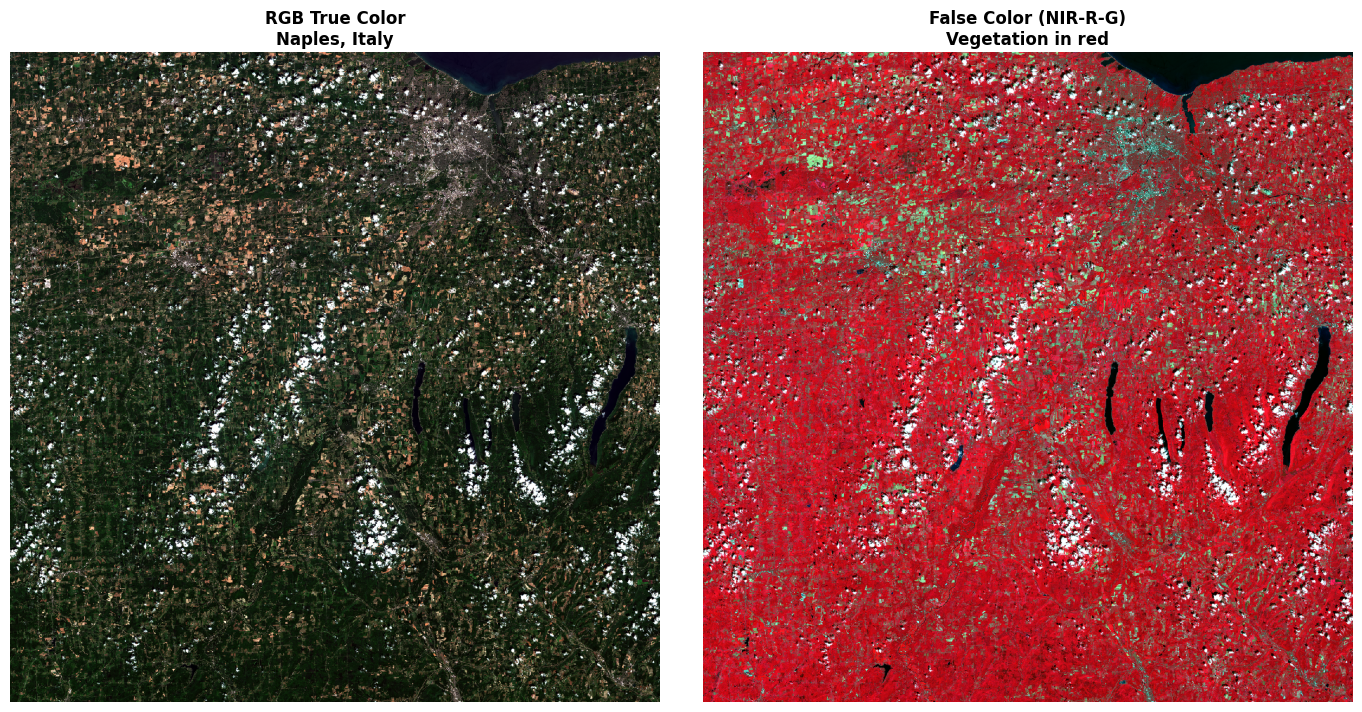

✅ Preview complete (1098×1098 pixels)


In [5]:
# ========================================
# 🖼️ Preview RGB Composite
# ========================================
# Quick visual check of downloaded satellite bands

try:
    import rasterio
    
    bands_dir = project_root / "data" / "cities" / CITY / "bands"
    
    if bands_dir.exists():
        # Load bands with recursive search
        def load_band_preview(band_name: str, max_dim: int = 1000):
            """Load and downsample band for preview"""
            for ext in [".jp2", ".tif", ".TIF"]:
                # Try direct path first
                path = bands_dir / f"{band_name}{ext}"
                if path.exists():
                    with rasterio.open(path) as src:
                        scale = max(src.height // max_dim, src.width // max_dim, 1)
                        data = src.read(1, out_shape=(src.height // scale, src.width // scale))
                        return data.astype(np.float32)
                
                # Try recursive search
                matches = list(bands_dir.rglob(f"**/{band_name}{ext}"))
                if matches:
                    with rasterio.open(matches[0]) as src:
                        scale = max(src.height // max_dim, src.width // max_dim, 1)
                        data = src.read(1, out_shape=(src.height // scale, src.width // scale))
                        return data.astype(np.float32)
            return None
        
        # Load RGB bands
        b04 = load_band_preview("B04")  # Red
        b03 = load_band_preview("B03")  # Green  
        b02 = load_band_preview("B02")  # Blue
        b08 = load_band_preview("B08")  # NIR
        
        if b04 is not None and b03 is not None and b02 is not None:
            # Histogram stretch
            def stretch(arr, percentile=2):
                p_low = np.nanpercentile(arr, percentile)
                p_high = np.nanpercentile(arr, 100 - percentile)
                return np.clip((arr - p_low) / (p_high - p_low + 1e-6), 0, 1)
            
            # Create composites
            rgb = np.stack([stretch(b04), stretch(b03), stretch(b02)], axis=-1)
            
            if b08 is not None:
                fig, axes = plt.subplots(1, 2, figsize=(14, 7))
                axes[0].imshow(rgb)
                axes[0].set_title(f'RGB True Color\n{CITY_DISPLAY}', fontsize=12, fontweight='bold')
                axes[0].axis('off')
                
                fcc = np.stack([stretch(b08), stretch(b04), stretch(b03)], axis=-1)
                axes[1].imshow(fcc)
                axes[1].set_title('False Color (NIR-R-G)\nVegetation in red', fontsize=12, fontweight='bold')
                axes[1].axis('off')
            else:
                fig, ax = plt.subplots(figsize=(10, 10))
                ax.imshow(rgb)
                ax.set_title(f'RGB True Color\n{CITY_DISPLAY}', fontsize=12, fontweight='bold')
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            print(f"✅ Preview complete ({rgb.shape[0]}×{rgb.shape[1]} pixels)")
        else:
            print("⚠️ Could not load bands for preview")
    else:
        print(f"⚠️ Bands directory not found: {bands_dir}")
        print("   Skip this cell or run cell 5 to download")
        
except ImportError:
    print("⚠️ rasterio not installed. Skip preview or: pip install rasterio")
except Exception as e:
    print(f"⚠️ Preview failed: {e}")
    print("   This is OK - continue to analysis")

In [ ]:
# ========================================
# 🚀 Run Analysis
# ========================================

clusters_str = f" ({N_CLUSTERS} clusters)" if CLASSIFIER in ("kmeans", "consensus") else ""
raw_str = " [RAW]" if RAW_CLUSTERS and CLASSIFIER == "kmeans" else ""
print(f"🛰️ Analyzing {CITY_DISPLAY}...")
print(f"   Classifier: {CLASSIFIER}{clusters_str}{raw_str}")
print(f"   Radius: {RADIUS_KM} km | Cloud ≤{MAX_CLOUD_COVER}% | Crop: {CROP_TO_CITY}")
print(f"   ⚠️ Auto-download disabled - use Cell 5 to download products first")

result = analyze(
    CITY,
    start_date=START_DATE,
    end_date=END_DATE,
    cloud_cover=MAX_CLOUD_COVER,
    radius_km=RADIUS_KM,
    max_size=MAX_SIZE,
    crop_to_city=CROP_TO_CITY,
    classifier=CLASSIFIER,
    n_clusters=N_CLUSTERS,
    raw_clusters=RAW_CLUSTERS,  # NEW: Keep all clusters distinct
    auto_download=False,  # Disable automatic download - use Cell 5 instead
)

# Summary
print(f"\n{result.summary()}")
print(f"\n📊 Classes found: {sorted(set(result.labels.flatten()))}")

🛰️ Analyzing Naples, Italy...
   Classifier: kmeans (6 clusters) [RAW]
   Radius: 10 km | Cloud ≤25% | Crop: True

Analysis Result for naples_italy
  Shape: (2087, 2035)
  Classes: 6
  Confidence: 70.0%
  Downsampled: False
  Output: C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\naples_italy\runs\2026-01-02_11-03-52_kmeans
  Time: 48.5s

📊 Classes found: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5)]


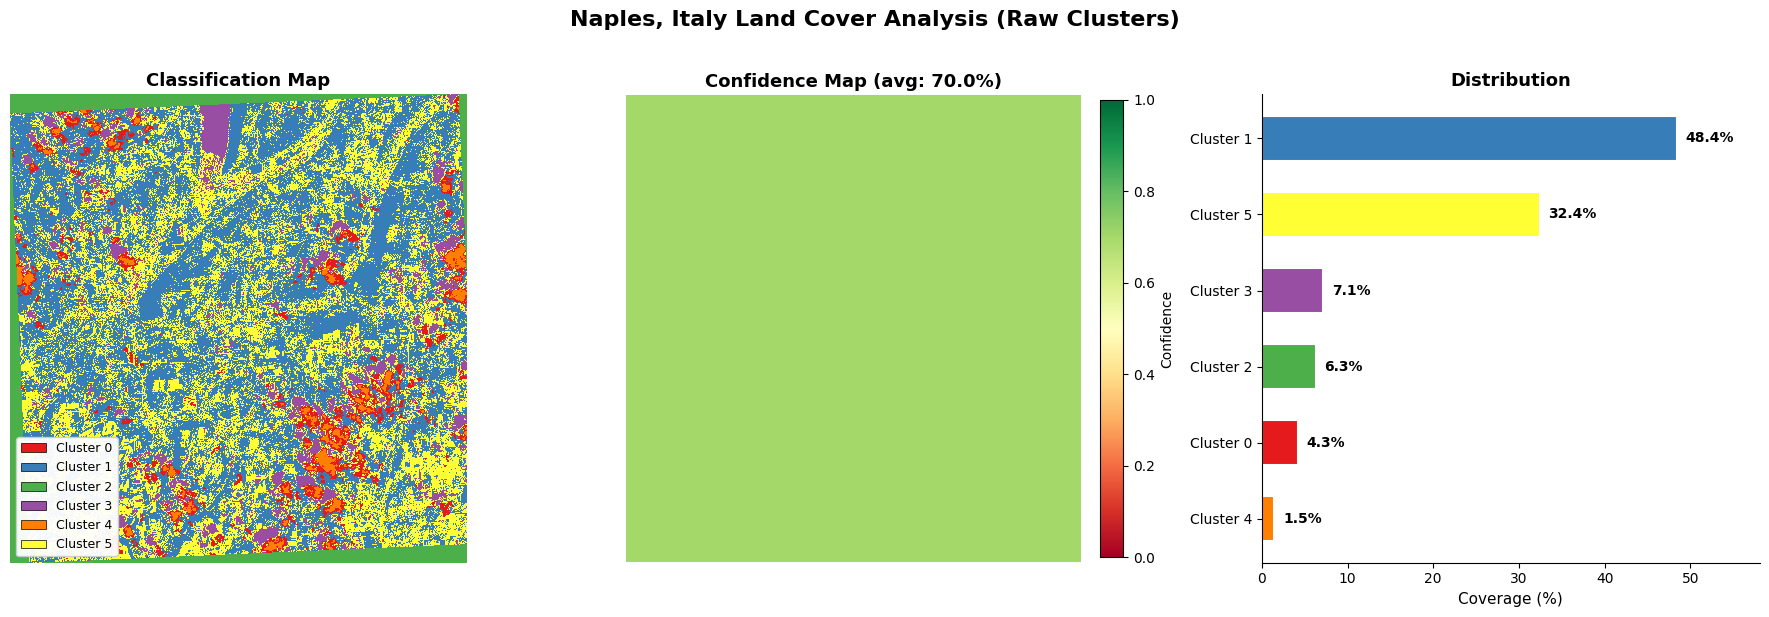


╔══════════════════════════════════════════════════════════╗
║  📊 Analysis Summary                                     ║
╠══════════════════════════════════════════════════════════╣
║  City:          naples_italy                             ║
║  Image size:    2,087 × 2,035 pixels       ║
║  Total pixels:  4,247,045                               ║
║  Confidence:    70.0%                                   ║
║  Classes found: 6                                       ║
║  Mode:          Raw Clusters                             ║
║  Time:          48.5s                                   ║
╚══════════════════════════════════════════════════════════╝

📁 Output: C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\naples_italy\runs\2026-01-02_11-03-52_kmeans



In [7]:
# ========================================
# 🗺️ Visualize Results
# ========================================

# Reload class definitions (colors may have been updated)
from importlib import reload
import satellite_analysis.exports
reload(satellite_analysis.exports)
from satellite_analysis.exports import LAND_COVER_CLASSES
CLASSES = {k: {"name": v["name"], "color": v["color"]} for k, v in LAND_COVER_CLASSES.items()}

# Get unique classes in result
unique_classes = sorted(np.unique(result.labels))
n_classes = len(unique_classes)

# Check if we're in raw_clusters mode
is_raw_mode = result.classification.statistics.get("mode") == "raw_clusters"

# For raw clusters, use a distinct colormap
if is_raw_mode:
    # High-contrast palette for raw clusters
    RAW_COLORS = [
        "#E41A1C",  # Red
        "#377EB8",  # Blue  
        "#4DAF4A",  # Green
        "#984EA3",  # Purple
        "#FF7F00",  # Orange
        "#FFFF33",  # Yellow
        "#A65628",  # Brown
        "#F781BF",  # Pink
        "#999999",  # Gray
        "#66C2A5",  # Teal
    ]
    colors = [RAW_COLORS[i % len(RAW_COLORS)] for i in unique_classes]
    class_names_map = {i: f"Cluster {i}" for i in unique_classes}
else:
    colors = [CLASSES.get(i, {"color": "#808080"})["color"] for i in unique_classes]
    class_names_map = {i: CLASSES.get(i, {"name": f"Class {i}"})["name"] for i in unique_classes}

cmap = ListedColormap(colors)

# Create figure with dark style for better contrast
plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
mode_str = " (Raw Clusters)" if is_raw_mode else ""
fig.suptitle(f'{CITY_DISPLAY} Land Cover Analysis{mode_str}', fontsize=16, fontweight='bold', y=1.02)

# 1. Land cover classification
ax1 = axes[0]
im1 = ax1.imshow(result.labels, cmap=cmap, interpolation='nearest',
                 vmin=min(unique_classes), vmax=max(unique_classes))
ax1.set_title('Classification Map', fontsize=13, fontweight='bold')
ax1.axis('off')

# Add legend with better styling
legend_elements = [Patch(facecolor=colors[i], 
                         edgecolor='black', linewidth=0.5,
                         label=class_names_map[unique_classes[i]]) 
                   for i in range(len(unique_classes))]
ax1.legend(handles=legend_elements, loc='lower left', fontsize=9,
           framealpha=0.95, fancybox=True)

# 2. Confidence map with better colormap
ax2 = axes[1]
conf_cmap = plt.colormaps.get_cmap('RdYlGn')
im2 = ax2.imshow(result.confidence, cmap=conf_cmap, vmin=0, vmax=1)
ax2.set_title(f'Confidence Map (avg: {result.avg_confidence:.1%})', fontsize=13, fontweight='bold')
ax2.axis('off')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Confidence', fontsize=10)

# 3. Class distribution with improved styling
ax3 = axes[2]
dist = result.class_distribution()
class_names = [class_names_map.get(i, f"Class {i}") for i in dist.keys()]
percentages = [d['percentage'] for d in dist.values()]
colors_bar = [colors[list(unique_classes).index(i)] if i in unique_classes else "#808080" 
              for i in dist.keys()]

# Sort by percentage for better visualization
sorted_idx = np.argsort(percentages)[::-1]
class_names = [class_names[i] for i in sorted_idx]
percentages = [percentages[i] for i in sorted_idx]
colors_bar = [colors_bar[i] for i in sorted_idx]

bars = ax3.barh(class_names, percentages, color=colors_bar, 
                edgecolor='white', linewidth=1.5, height=0.6)
ax3.set_xlabel('Coverage (%)', fontsize=11)
ax3.set_title('Distribution', fontsize=13, fontweight='bold')
ax3.set_xlim(0, max(percentages) * 1.2)
ax3.invert_yaxis()

# Add percentage labels
for bar, pct in zip(bars, percentages):
    width = bar.get_width()
    ax3.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'{pct:.1f}%', va='center', fontsize=10, fontweight='bold')

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(result.output_dir / f"{CITY.lower()}_classification.png", dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# Print summary stats
print(f"""
╔══════════════════════════════════════════════════════════╗
║  📊 Analysis Summary                                     ║
╠══════════════════════════════════════════════════════════╣
║  City:          {CITY:<40} ║
║  Image size:    {result.labels.shape[0]:,} × {result.labels.shape[1]:,} pixels{' '*(27-len(f'{result.labels.shape[0]:,} × {result.labels.shape[1]:,} pixels'))}║
║  Total pixels:  {result.total_pixels:,}{' '*(40-len(f'{result.total_pixels:,}'))}║
║  Confidence:    {result.avg_confidence:.1%}{' '*(40-len(f'{result.avg_confidence:.1%}'))}║
║  Classes found: {len(unique_classes)}{' '*(40-len(str(len(unique_classes))))}║
║  Mode:          {'Raw Clusters' if is_raw_mode else 'Semantic Classes':<40} ║
║  Time:          {result.execution_time:.1f}s{' '*(40-len(f'{result.execution_time:.1f}s'))}║
╚══════════════════════════════════════════════════════════╝

📁 Output: {result.output_dir}
""")

📁 Export directory: C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\naples_italy\runs\2026-01-02_11-03-52_kmeans



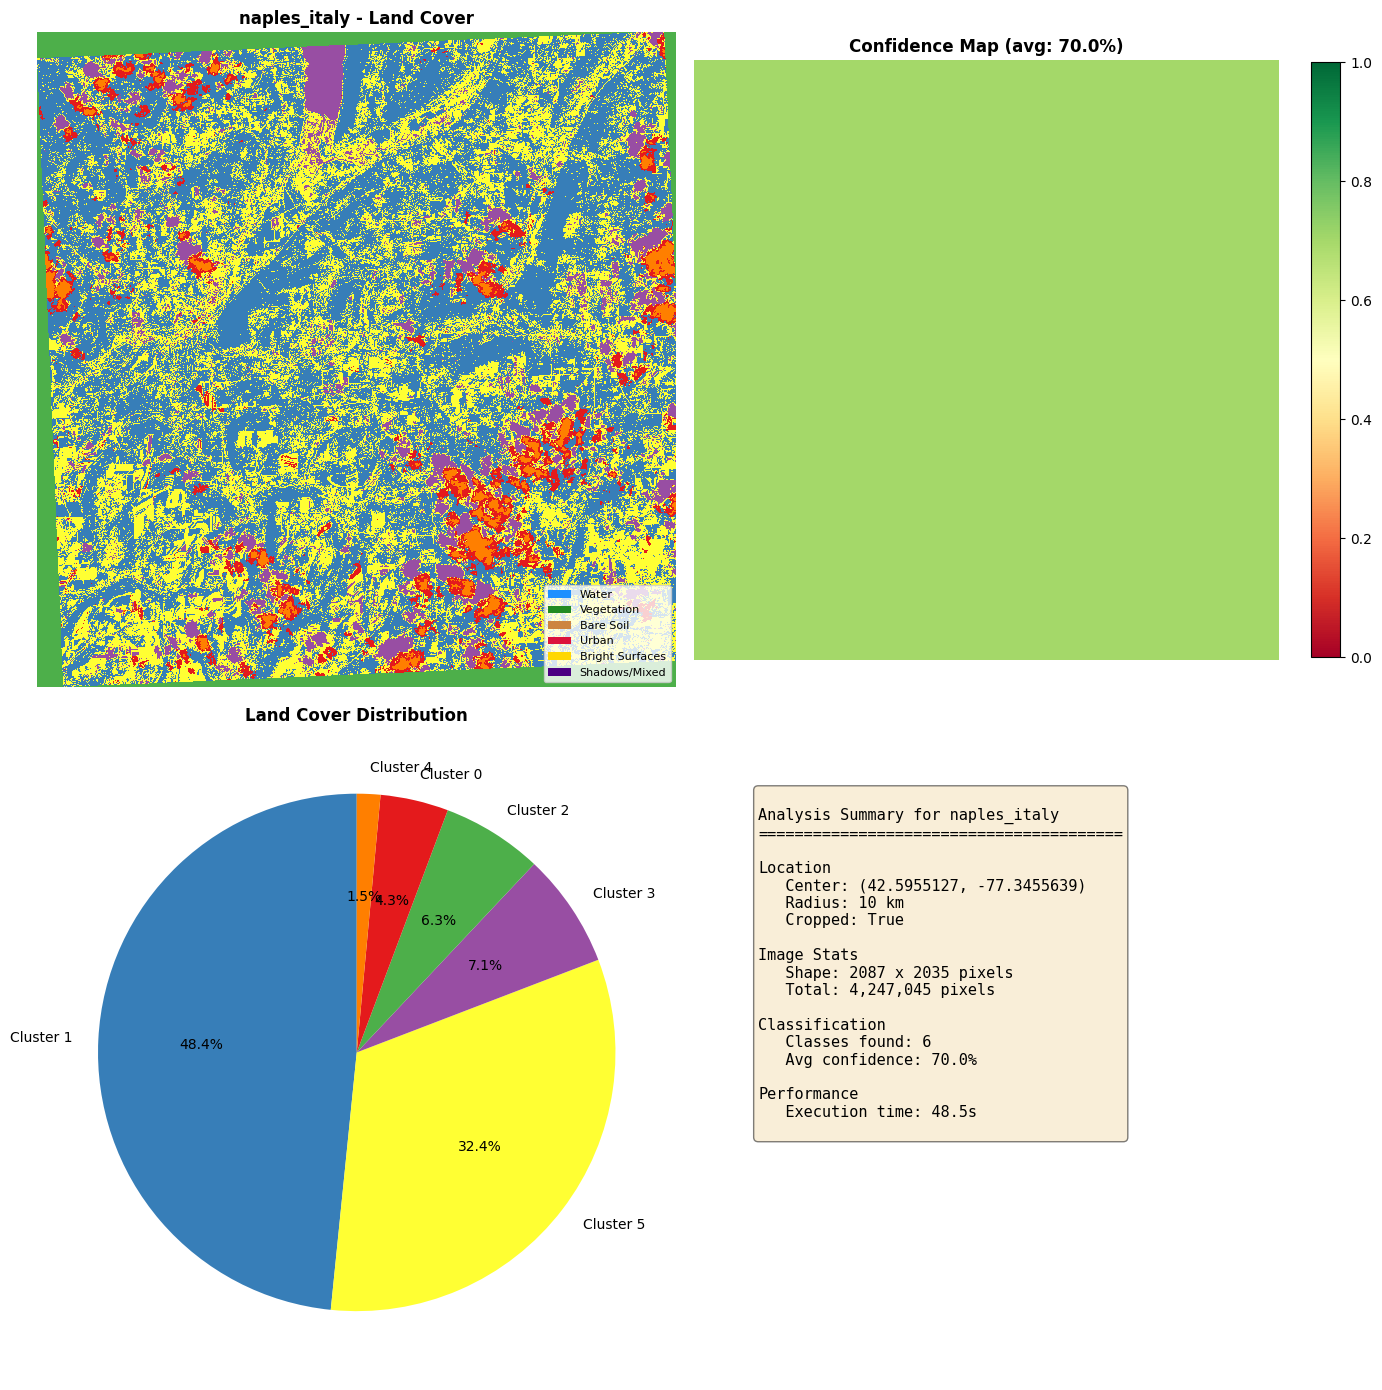


📸 Generating RGB composites from satellite bands...
✅ RGB True Color: C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\naples_italy\exports\naples_italy_rgb.png
✅ False Color (vegetation): C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\naples_italy\exports\naples_italy_fcc.png

📦 Generating analysis exports...
✅ PNG Summary: naples_italy_summary.png
✅ GeoTIFF: naples_italy_landcover.tif
✅ JSON: naples_italy_data.json
✅ HTML Report: naples_italy_report.html

📁 All exports saved to: C:\TEMP_1\satellite_git_vt\satellite_git\data\cities\naples_italy\runs\2026-01-02_11-03-52_kmeans


In [ ]:
# ========================================
# 💾 Export Results
# ========================================

# Create output directory for exports
export_dir = result.output_dir
print(f"📁 Export directory: {export_dir}\n")

# 1. Save detailed classification image (separate panels)
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 14))

# Classification map
ax = axes2[0, 0]
im = ax.imshow(result.labels, cmap=cmap, interpolation='nearest',
               vmin=min(unique_classes), vmax=max(unique_classes))
ax.set_title(f'{CITY} - Land Cover', fontsize=12, fontweight='bold')
ax.axis('off')
# Use the same legend from the main visualization
legend_elements = [Patch(facecolor=colors[list(unique_classes).index(i)] if i in unique_classes else "#808080",
                         label=class_names_map.get(i, f"Class {i}")) 
                   for i in unique_classes]
ax.legend(handles=legend_elements, loc='lower right', fontsize=8)

# Confidence map
ax = axes2[0, 1]
im2 = ax.imshow(result.confidence, cmap='RdYlGn', vmin=0, vmax=1)
ax.set_title(f'Confidence Map (avg: {result.avg_confidence:.1%})', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im2, ax=ax, fraction=0.046)

# Distribution pie chart
ax = axes2[1, 0]
wedges, texts, autotexts = ax.pie(
    percentages, 
    labels=class_names, 
    colors=colors_bar,
    autopct='%1.1f%%',
    startangle=90
)
ax.set_title('Land Cover Distribution', fontsize=12, fontweight='bold')

# Stats text
ax = axes2[1, 1]
ax.axis('off')
stats_text = f"""
Analysis Summary for {CITY}
{'='*40}

Location
   Center: {result.city_center if result.city_center else 'N/A'}
   Radius: {result.radius_km} km
   Cropped: {result.cropped_to_city}

Image Stats
   Shape: {result.labels.shape[0]} x {result.labels.shape[1]} pixels
   Total: {result.total_pixels:,} pixels
   
Classification
   Classes found: {len(unique_classes)}
   Avg confidence: {result.avg_confidence:.1%}
   
Performance
   Execution time: {result.execution_time:.1f}s
"""
ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(export_dir / f"{CITY.lower()}_full_report.png", dpi=150, bbox_inches='tight')
plt.show()

# ========================================
# 🖼️ Export RGB True Color & Band Composites
# ========================================
print("\n📸 Generating RGB composites from satellite bands...")
try:
    rgb_paths = export_rgb(CITY, dpi=100, include_ndvi=False)
    print(f"✅ RGB True Color: {rgb_paths.get('rgb', 'N/A')}")
    print(f"✅ False Color (vegetation): {rgb_paths.get('fcc', 'N/A')}")
    if 'ndvi' in rgb_paths:
        print(f"✅ NDVI visualization: {rgb_paths.get('ndvi', 'N/A')}")
    if 'rgb_geotiff' in rgb_paths:
        print(f"✅ RGB GeoTIFF: {rgb_paths['rgb_geotiff']}")
except Exception as e:
    print(f"⚠️ RGB export skipped: {e}")

# ========================================
# 📊 Standard Exports
# ========================================
print("\n📦 Generating analysis exports...")

# PNG summary (shareable quick-look)
try:
    summary_path = export_dir / f"{CITY.lower()}_summary.png"
    export_image(result, str(summary_path))
    print(f"✅ PNG Summary: {summary_path.name}")
except Exception as e:
    print(f"⚠️ PNG export skipped: {e}")

# GeoTIFF (for GIS)
try:
    geotiff_path = export_dir / f"{CITY.lower()}_landcover.tif"
    export_geotiff(result, str(geotiff_path))
    print(f"✅ GeoTIFF: {geotiff_path.name}")
except Exception as e:
    print(f"⚠️ GeoTIFF export skipped: {e}")

# JSON (machine-readable)
try:
    json_path = export_dir / f"{CITY.lower()}_data.json"
    export_json(result, str(json_path))
    print(f"✅ JSON: {json_path.name}")
except Exception as e:
    print(f"⚠️ JSON export skipped: {e}")

# HTML report
try:
    html_path = export_dir / f"{CITY.lower()}_report.html"
    export_report(result, str(html_path), language="en")
    print(f"✅ HTML Report: {html_path.name}")
except Exception as e:
    print(f"⚠️ HTML export skipped: {e}")

print(f"\n📁 All exports saved to: {export_dir}")